# Random Masking (MADE style)

In [2]:
import os
import pdb
import numpy as np
import torch
from torchtext import data, datasets
from collections import OrderedDict as OD
import matplotlib.pyplot as plt

from transformer import * 
from utils       import * 
from custom_ds   import CustomDataset

import seaborn as sns
sns.set(font_scale=1.5)  
sns.set_style("whitegrid")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

VERBOSE = True


### Build Dataset & Model

In [3]:
def load_data(train_file='train.txt', valid_file='valid.txt', test_file='test.txt', path=None, **kwargs):
    if path is not None:
        train_file, valid_file, test_file = [os.path.join(path, ext) for ext in [train_file, valid_file, test_file]]

    # create required field for language modeling
    input_field = data.Field(lower=True, batch_first=True)
    fields = [("text", input_field)]

    train_set, valid_set, test_set  = CustomDataset.splits(fields, train_file, valid_file, test_file)
    input_field.build_vocab(train_set)

    train_loader, val_loader, test_loader = data.Iterator.splits(
      (train_set, valid_set, test_set),
      sort_key=lambda x : len(x.text),
      batch_sizes=(256, 512, 512),
      **kwargs)

    return input_field, train_loader, val_loader, test_loader

# train_iter, val_iter, test_iter = datasets.PennTreebank.iters(batch_size=512)
input_field, train_iter, val_iter, test_iter = load_data(path='data/news', device=0, repeat=False)
iterators = {'train': train_iter, 'valid': val_iter, 'test': test_iter}
VOCAB_SIZE = 10000 + 1

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [4]:
# create model and ship to GPU
gen  = make_model(VOCAB_SIZE, N=2, h=4).cuda()
# print(gen)
print('number of params', sum([np.prod([int(y) for y in x.shape]) for x in gen.parameters()]))

# build optimizer
optimizer_gen = torch.optim.Adam(gen.parameters())

number of params 16556817


### Loop over the whole dataset 

In [9]:
def full_epoch(epoch_no, split, mask_type='left to right'):
    loader = iterators[split]

    # create logging containers
    logs = OD()
    for name in ['nll', 'ppl']:
        logs[name] = []

    gen.train() if split == 'train' else gen.eval()

    # Training loop
    for i, minibatch in enumerate(loader):
        
        text = minibatch.text.cuda()
        input = text
        
        if mask_type == 'left to right':
            input = text[:, :-1]
            target = text[:, 1:]
            masks = make_std_mask(target, 0)
            # no masking
            mask = torch.ones_like(target) #(target != 1) or (target == 1)
            tt = None
        elif mask_type == 'random':
            lens = (text != 1).sum(dim=1).byte().cpu().data.numpy()
            masks, orders, tt = [torch.from_numpy(x).long().cuda() for x in build_ar_masks(lens)]
            
            offset = (torch.arange(orders.size(0)) * (orders.size(1))).unsqueeze(1).long().cuda()
            new_order = torch.take(input,  offset + tt)
            target = new_order
            
            # one token per sentence does not have a target anymore, here is the mask to mask it out
            mask_eos = tt != -1  # -1 was used to denote the target of the last token
            mask_pad = text != 1 #  1 is <PAD> token
            mask = torch.min(mask_eos, mask_pad)
            
            tt = tt.clamp(min=0)
            
        else:
            raise ValueError('%s is an invalid mask type' % mask_type)

        bs, seq_len = input.size()
        # we pass in the target so that the model can see the positional embedding of the word it needs to predict
        logits = gen(input, masks, target_pos=tt)
        
        recon_loss = F.cross_entropy(logits.view(bs * seq_len, -1), target.flatten(), reduction='none')
        recon_loss = recon_loss.reshape(*input.size())
        
        # mask out the conditionals with no target and mask out the pad tokens
        recon_loss = recon_loss * mask.float()
        recon_loss = recon_loss.sum() / mask.sum().float()

        if gen.training:
             optimizer_gen.zero_grad()
             recon_loss.backward()
             params = optimizer_gen.param_groups[0]['params']
             torch.nn.utils.clip_grad_norm_(params, 10, norm_type=2)
             optimizer_gen.step()
         
        logs['nll']  += [recon_loss.data]
        logs['ppl']  += [recon_loss.exp().data]

    return logs

### Plot perplexity graphs 

In [10]:
def plot(train_ppl, valid_ppl, title):
    train, valid = [], []
    for tt, vv in zip(train_ppl, valid_ppl):
        train += [torch.stack(tt).mean().item()]
        valid += [torch.stack(vv).mean().item()]
        
    plt.scatter(np.arange(len(train)), train, label='train ppl')
    plt.scatter(np.arange(len(valid)), valid, label='valid ppl')
    plt.legend()
    plt.hlines(min(valid), 0, len(valid), linestyles='dashed')
    plt.ylim(bottom=0)
    plt.xlim(-0.1, len(valid))
    plt.yticks([min(valid)] + [x for x in np.linspace(0, max(train + valid), 5)][1:])
    plt.title(title)
    plt.show()   

In [11]:
def build_ar_masks(lens):
    max_len = max(lens)
    masks, orders, targets = [], [], []
    for len_ in lens:
        arr = np.arange(len_)
        np.random.shuffle(arr)

        arr = np.concatenate([arr, np.arange(len_, max_len)])

        orders += [arr]

        rev = [arr[arr[j]] for j in range(len_)]
        target = []
        mask = np.zeros((max_len, max_len))
        for j, row in enumerate(mask[:len_]):
            # row[i] = 1
            # find index with i
            index = np.where(arr == j)[0][0]
            row[arr[:index]] = 1

            if index < len_ - 1: # not last
                target += [arr[index+1]]
            else:
                target += [-1]

        target += [-1] * (max_len - len(target))
        mask = mask + np.eye(mask.shape[0])
        mask[len_:, len_:] = 0

        masks += [mask]
        targets += [target]

    return np.stack(masks), np.stack(orders), np.stack(targets)

### Exp2 : Proposed Model (random ordering masking for training and eval)

In [18]:
VERBOSE = True
#gen  = make_model(len(input_field.vocab.itos), N=2, h=4).cuda()
#optimizer_gen = torch.optim.Adam(gen.parameters())

#train_ppl, valid_ppl, writes = [], [], 0

for epoch in range(10):
    train_log  = full_epoch(epoch, 'train', mask_type = 'left to right')
    train_ppl += [train_log['ppl']]

    if VERBOSE: 
        for key, value in train_log.items():
            print_scalar('train/%s' % key, value, writes)
        print('')
    
    with torch.no_grad():
        valid_log  = full_epoch(epoch, 'valid', mask_type='left to right')
        valid_ppl += [valid_log['ppl']]

        if VERBOSE: 
            for key, value in valid_log.items():
                print_scalar('valid/%s' % key, value, writes)
            print('')
        
    writes += 1

train/nll                                @ write 12 = 1.9289
train/ppl                                @ write 12 = 6.8939

valid/nll                                @ write 12 = 3.5248
valid/ppl                                @ write 12 = 34.2142

train/nll                                @ write 13 = 1.9230
train/ppl                                @ write 13 = 6.8551

valid/nll                                @ write 13 = 3.5268
valid/ppl                                @ write 13 = 34.2742



KeyboardInterrupt: 

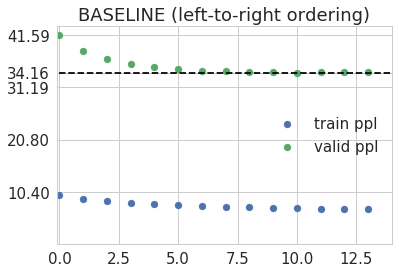

In [19]:
plot(train_ppl, valid_ppl, 'BASELINE (left-to-right ordering)')

### Sample from model

In [20]:
def greedy_decode(model, max_len, start_symbol=2, take_max=True):
    ys = torch.ones(1, 1).fill_(start_symbol).long().cuda()
    for i in range(max_len-1):
        out = model.decode(
                           ys,
                           (subsequent_mask(ys.size(1)).type_as(ys)), target_pos=None)
        prob = model.generator(out[:, -1])
        if take_max:
            _, next_word = torch.max(prob, dim = 1)
        else:
            dist = torch.distributions.Categorical(prob.exp())
            next_word = dist.sample()
        next_word = next_word.data[0]
        ys = torch.cat([ys,
                        torch.ones(1, 1).long().fill_(next_word).cuda()], dim=1)
        ys = ys.cuda()
    return ys

def low_entropy_decoding(model, max_len, sos_token, pad_token):
    ys = torch.ones(1, max_len).fill_(pad_token).long().cuda()
    ys[0, 0] = sos_token

    mask = torch.zeros(1, max_len, max_len).byte().cuda()
    
    # all tokens can look at the sos token
    mask[:, :, 0] = 1
  
    target_pos = torch.arange(max_len).unsqueeze(0).long().cuda()

    for t in range(max_len):
        out  = model.decode(ys, mask, target_pos)
        prob = model.generator(out)
        dist = torch.distributions.Categorical(prob.squeeze().exp())

        entropies = dist.entropy()                
        # zero-out words that have already been generated
        mask_t = (ys != pad_token).squeeze()
        entropies.masked_fill_(mask_t, 999999)

        position = entropies.argmin()
        sample = dist.sample()[position]

        # update the mask to take into account this new word
        mask[:, :, position] = 1
        ys[:, position] = sample
        
    return ys
    
        
def to_readable(vocab, matrix):
    if isinstance(vocab, torchtext.data.field.Field):
        vocab = vocab.vocab.itos

    sentences = []
    for line in matrix:
        sentence = ''
        for token in line:
            sentence += vocab[token] + ' '
        sentence = sentence.replace('<pad>', '')
        sentences += [sentence]
    return sentences

In [24]:
out = greedy_decode(gen, 51, take_max=False)
print(out)
print(to_readable(input_field, out))
out = low_entropy_decoding(gen, 51, 0, 1)
print(to_readable(input_field , out))

tensor([[   2,  590,   26,   28,   22,   54,  262, 1512,    5, 1131,   20,  699,
          244,   30,    2, 2811, 2508,   10,    2,  987, 4269,    9,    2, 1271,
         1431, 4451,    3,    2,  135, 1021,   24,    4,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1]], device='cuda:0')
['the staff but they have so far declined to comment on cases such as the usual suspects in the latest string of the murder terror plot , the police source said .                    ']
['<unk>                       for           to                 ']


### Exp1 : Baseline Model (left to right masking for training and eval)

In [ ]:
VERBOSE = True
gen  = make_model(len(input_field.vocab.itos), N=2, h=4).cuda()
optimizer_gen = torch.optim.Adam(gen.parameters())

train_ppl, valid_ppl, writes = [], [], 0

for epoch in range(10):
    train_log  = full_epoch(epoch, 'train', mask_type = 'left to right')
    train_ppl += [train_log['ppl']]

    if VERBOSE: 
        for key, value in train_log.items():
            print_scalar('train/%s' % key, value, writes)
        print('')
    
    with torch.no_grad():
        valid_log  = full_epoch(epoch, 'valid')
        valid_ppl += [valid_log['ppl']]

        if VERBOSE: 
            for key, value in valid_log.items():
                print_scalar('valid/%s' % key, value, writes)
            print('')
        
    writes += 1

In [ ]:
plot(train_ppl[2:], valid_ppl[2:], 'LM-MADE (random train/test masks)')

In [ ]:
out = greedy_decode(gen, 51, take_max=False)
print(to_readable(input_field, out))
out = low_entropy_decoding(gen, 51, 0, 16)

### Comments on results 

Perplexity wise, these results are very promising. Let's see if this gain simply comes from evaluating with random orderings, or that training with random masks actually helps. To do so, we train using the regular ordering, and evaluate with random masks

In [ ]:
VERBOSE = False
gen  = make_model(10000 + 1, N=2, h=4).cuda()
optimizer_gen = torch.optim.Adam(gen.parameters())

train_ppl, valid_ppl, writes = [], [], 0

for epoch in range(10):
    train_log  = full_epoch(epoch, 'train', mask_type = 'left to right')
    train_ppl += [train_log['ppl']]

    if VERBOSE: 
        for key, value in train_log.items():
            print_scalar('train/%s' % key, value, writes)
        print('')
    
    with torch.no_grad():
        valid_log  = full_epoch(epoch, 'valid', mask_type='random')
        valid_ppl += [valid_log['ppl']]

        if VERBOSE: 
            for key, value in valid_log.items():
                print_scalar('valid/%s' % key, value, writes)
            print('')
        
    writes += 1

In [ ]:
plot(train_ppl, valid_ppl, 'regular training, random mask for testing')

Last thing to try : Train on random orderings but evaluate only on left-to-right orderings

In [ ]:
VERBOSE = False
gen  = make_model(10000 + 1, N=2, h=4).cuda()
optimizer_gen = torch.optim.Adam(gen.parameters())

train_ppl, valid_ppl, writes = [], [], 0

for epoch in range(10):
    train_log  = full_epoch(epoch, 'train', mask_type = 'random')
    train_ppl += [train_log['ppl']]

    if VERBOSE: 
        for key, value in train_log.items():
            print_scalar('train/%s' % key, value, writes)
        print('')
    
    with torch.no_grad():
        valid_log  = full_epoch(epoch, 'valid', mask_type='left to right')
        valid_ppl += [valid_log['ppl']]

        if VERBOSE: 
            for key, value in valid_log.items():
                print_scalar('valid/%s' % key, value, writes)
            print('')
        
    writes += 1

In [ ]:
plot(train_ppl, valid_ppl, 'random training, left-to-right testing')